<a href="https://colab.research.google.com/github/inci-bakimci/agProgramlama/blob/main/MarketAnalizi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from itertools import permutations
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import networkx as nx
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly
import igraph as ig
from plotly.graph_objs import *

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


# **1.Veri Ön İşleme**

In [ ]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10)
#ciktinin tek bir satirda olmasini saglar.
pd.set_option('display.expand_frame_repr',False)
df = pd.read_csv("/content/Groceries data.csv")
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4
...,...,...,...,...,...,...,...
38760,4471,2014-08-10,sliced cheese,2014,8,10,6
38761,2022,2014-02-23,candy,2014,2,23,6
38762,1097,2014-04-16,cake bar,2014,4,16,2
38763,1510,2014-03-12,fruit/vegetable juice,2014,3,12,2


In [ ]:
#üye kimliği ve ürünlerin benzersiz değerleri
print(len(df['Member_number'].unique()))
print(len(df['itemDescription'].unique()))

3898
167


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
freq_items = df['itemDescription'].value_counts()
freq_items.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



itemDescription
whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: count, dtype: int64

In [ ]:
#  en çok satılan ürünleri görmek için bir çubuk grafik çizin
fig = px.bar(data_frame=freq_items.head(10), title='En çok satılan 10 ürün', color=freq_items.head(10),
                 labels={
                     "index": "Items",
                     "values": "Quantity"
                 })
fig.update_layout(title_x=0.5, title_y=0.86)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# **2.ARL Veri Yapısının Hazırlanması**

In [ ]:
# öğeleri üye kimliklerine göre listele
user_id = df['Member_number'].unique()
items = [list(df.loc[df['Member_number'] == id, 'itemDescription']) for id in user_id]
print(items[0])

# items_df = pd.DataFrame(items)
# items_df.head()

# user_id_df = pd.DataFrame(user_id)
# user_id_df.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['tropical fruit', 'long life bakery product', 'meat', 'sugar', 'rolls/buns', 'semi-finished bread', 'whole milk', 'citrus fruit', 'candy', 'napkins']


In [ ]:
# her kullanıcının sepet listesi
items_df = pd.DataFrame(items)
items_df.head()
#items_df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,tropical fruit,long life bakery product,meat,sugar,rolls/buns,semi-finished bread,whole milk,citrus fruit,candy,napkins,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,whole milk,butter,female sanitary products,pot plants,other vegetables,tropical fruit,root vegetables,whole milk,shopping bags,chocolate,chocolate,coffee,hygiene articles,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,pip fruit,sausage,frankfurter,pork,other vegetables,white wine,long life bakery product,fruit/vegetable juice,flour,hygiene articles,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,other vegetables,soda,citrus fruit,onions,soda,domestic eggs,shopping bags,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,whole milk,cling film/bags,other vegetables,ham,white bread,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
#  Kullanıcı X  ürün matrisi oluştur
TE = TransactionEncoder()
TE.fit(items)
item_transformed = TE.transform(items)
item_matrix = pd.DataFrame(item_transformed, columns = TE.columns_)
item_matrix.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,curd,curd cheese,decalcifier,dental care,dessert,detergent,dish cleaner,dishes,dog food,domestic eggs,female sanitary products,finished products,fish,flour,flower (seeds),flower soil/fertilizer,frankfurter,frozen chicken,frozen dessert,frozen fish,frozen fruits,frozen meals,frozen potato products,frozen vegetables,fruit/vegetable juice,grapes,hair spray,ham,hamburger meat,hard cheese,herbs,honey,house keeping products,hygiene articles,ice cream,instant coffee,jam,ketchup,kitchen towels,kitchen utensil,light bulbs,liqueur,liquor,liquor (appetizer),liver loaf,long life bakery product,make up remover,male cosmetics,margarine,mayonnaise,meat,meat spreads,misc. beverages,mustard,napkins,newspapers,nut snack,nuts/prunes,oil,onions,organic products,organic sausage,other vegetables,packaged fruit/vegetables,pasta,pastry,pet care,photo/film,pickled vegetables,pip fruit,popcorn,pork,pot plants,potato products,preservation products,processed cheese,prosecco,pudding powder,ready soups,red/blush wine,rice,roll products,rolls/buns,root vegetables,rubbing alcohol,rum,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
2,False,Fa

In [ ]:
item_matrix.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



(3898, 167)

# **3.Birliktelik Kurallarının Çıkarılması**

In [ ]:
# Apriori algoritmasıyla destek değerleri
freq_items = apriori(item_matrix, min_support=0.01, use_colnames=True,)
freq_items.sort_values(by = "support", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
113,0.458184,(whole milk)
69,0.376603,(other vegetables)
84,0.349666,(rolls/buns)
94,0.313494,(soda)
114,0.282966,(yogurt)
...,...,...
2269,0.010005,"(ice cream, sausage, whole milk)"
2266,0.010005,"(ice cream, other vegetables, rolls/buns)"
2263,0.010005,"(other vegetables, herbs, whole milk)"
956,0.010005,"(pork, misc. beverages)"


In [ ]:
# support, confidence ve lift değerlerine sahip bir veri çerçevesi oluşturur.
rules = association_rules(freq_items, metric = "confidence", min_threshold = 0)
rules = rules.sort_values(by="confidence", ascending=False)
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
7198,"(meat, domestic eggs)",(whole milk),0.013084,0.458184,0.010262,0.784314,1.711789,0.004267,2.512057,0.421328
5864,"(fruit/vegetable juice, chocolate)",(whole milk),0.014366,0.458184,0.010775,0.750000,1.636898,0.004192,2.167265,0.394760
15360,"(rolls/buns, yogurt, other vegetables, bottled...",(whole milk),0.014110,0.458184,0.010518,0.745455,1.626978,0.004053,2.128564,0.390879
11847,"(bottled water, yogurt, pip fruit)",(whole milk),0.013853,0.458184,0.010262,0.740741,1.616689,0.003914,2.089863,0.386811
12210,"(rolls/buns, yogurt, brown bread)",(whole milk),0.017445,0.458184,0.012827,0.735294,1.604802,0.004834,2.046862,0.383561
...,...,...,...,...,...,...,...,...,...,...
15449,(whole milk),"(rolls/buns, shopping bags, other vegetables, ...",0.458184,0.014110,0.010005,0.021837,1.547613,0.003540,1.007899,0.653069
3006,(whole milk),"(frozen vegetables, bottled beer)",0.458184,0.017701,0.010005,0.021837,1.233604,0.001895,1.004227,0.349505
8419,(whole milk),"(ice cream, sausage)",0.458184,0.015393,0.010005,0.021837,1.418645,0.002953,1.006588,0.544653
3871,(whole milk),"(bottled water, meat)",0.458184,0.015136,0.010005,0.021837,1.442690,0.003070,1.006850,0.566336


In [ ]:
#kombinasyon yapılarak ürünler arasındaki ilişkilere bakılır.
rules[(rules['support']>0.05) & (rules['confidence']>0.1) & (rules['lift']>1.2)].\
sort_values("confidence", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3992,"(bottled water, other vegetables)",(whole milk),0.093894,0.458184,0.056183,0.598361,1.305941,0.013162,1.349012,0.258544
9776,"(other vegetables, yogurt)",(whole milk),0.120318,0.458184,0.071832,0.597015,1.303003,0.016704,1.344507,0.264348
10556,"(rolls/buns, yogurt)",(whole milk),0.111339,0.458184,0.065931,0.592166,1.292420,0.014917,1.328521,0.254605
9482,"(rolls/buns, other vegetables)",(whole milk),0.146742,0.458184,0.082093,0.559441,1.220996,0.014859,1.229837,0.212124
10928,"(soda, yogurt)",(whole milk),0.097486,0.458184,0.054387,0.557895,1.217622,0.009720,1.225537,0.198033
9680,"(soda, other vegetables)",(whole milk),0.124166,0.458184,0.069266,0.557851,1.217528,0.012375,1.225416,0.203992
9722,"(tropical fruit, other vegetables)",(whole milk),0.091329,0.458184,0.050539,0.553371,1.207749,0.008693,1.213123,0.189302
3993,"(bottled water, whole milk)",(other vegetables),0.112365,0.376603,0.056183,0.500000,1.327657,0.013865,1.246793,0.278035
9778,"(yogurt, whole milk)",(other vegetables),0.150590,0.376603,0.071832,0.477002,1.266589,0.015119,1.191967,0.247793
9488,"(rolls/buns, yogurt)",(other vegetables),0.111339,0.376603,0.052335,0.470046,1.248120,0.010404,1.176322,0.223701


# **4.Çalışma Scriptinin Hazırlanmasıl**

In [ ]:
def create_rules(DataFrame):
  freq_items = apriori(item_matrix, min_support=0.01, use_colnames=True)
  rules = association_rules(freq_items, metric = "confidence", min_threshold = 0.01)
  return rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df = pd.read_csv("/content/Groceries data.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
df = create_rules(df)
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(beef),(UHT-milk),0.119548,0.078502,0.010518,0.087983,1.120775,0.001133,1.010396,0.122392
1,(UHT-milk),(beef),0.078502,0.119548,0.010518,0.133987,1.120775,0.001133,1.016672,0.116940
2,(UHT-milk),(bottled beer),0.078502,0.158799,0.014879,0.189542,1.193597,0.002413,1.037933,0.176014
3,(bottled beer),(UHT-milk),0.158799,0.078502,0.014879,0.093700,1.193597,0.002413,1.016769,0.192815
4,(bottled water),(UHT-milk),0.213699,0.078502,0.021293,0.099640,1.269268,0.004517,1.023477,0.269801
...,...,...,...,...,...,...,...,...,...,...
15475,(yogurt),"(rolls/buns, other vegetables, whole milk, soda)",0.282966,0.031811,0.013597,0.048051,1.510499,0.004595,1.017059,0.471340
15476,(rolls/buns),"(soda, yogurt, other vegetables, whole milk)",0.349666,0.027963,0.013597,0.038885,1.390578,0.003819,1.011364,0.431893
15477,(soda),"(rolls/buns, yogurt, other vegetables, whole m...",0.313494,0.034377,0.013597,0.043372,1.261658,0.002820,1.009403,0.302098
15478,(other vegetables),"(rolls/buns, yogurt, whole milk, soda)",0.376603,0.024628,0.013597,0.036104,1.465954,0.004322,1.011905,0.509869


# **5.Sepet Aşamasındaki Kullanıcılara Ürün Önerisinde Bulunmak**

In [ ]:
def arl_recommender(rules_df, product_id, rec_count=1):
    sorted_rules = rules_df.sort_values("confidence", ascending=False)
    recommendation_list = []

    for _, rule in sorted_rules.iterrows():
        antecedents = rule['antecedents']
        consequents = rule['consequents']

        if product_id in antecedents:
            for item in consequents:
                if item not in recommendation_list:
                    recommendation_list.append(item)
                    if len(recommendation_list) == rec_count:
                        return recommendation_list

    return recommendation_list[0:rec_count]

# Fonksiyonu çağırma örneği
# rules_df, Apriori algoritmasıyla üretilmiş kuralların DataFrame'i olmalıdır
# product_id ise öneri almak istediğiniz ürün kimliği
arl_recommender(rules, "whole milk", 7)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['other vegetables',
 'rolls/buns',
 'yogurt',
 'soda',
 'bottled water',
 'sausage',
 'root vegetables']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



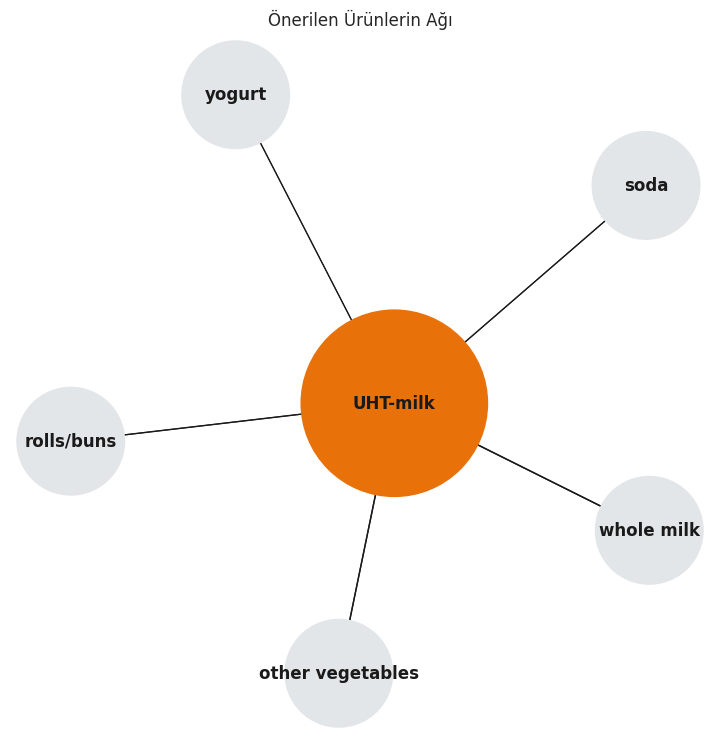

In [ ]:
def visualize_recommendations(rules_df, product_id, rec_count=10):
    # Önerilen ürünlerin listesini alın
    recommendation_list = arl_recommender(rules_df, product_id, rec_count)

    # Boş bir yönlendirilmemiş ağ oluşturun
    G = nx.Graph()

    # Yeni ürünü ağa ekleyin ve renklendirin
    G.add_node(product_id, label=str(product_id), color='#E8710A')

    # Önerilen ürünleri ağa ekleyin ve kalınlıklarını derecelerine göre belirleyin
    for recommended_product_id in recommendation_list:
        G.add_node(recommended_product_id, label=str(recommended_product_id))
        weight = rules_df[(rules_df['antecedents'] == frozenset({product_id})) &
                          (rules_df['consequents'] == frozenset({recommended_product_id}))]['confidence'].values[0]
        G.add_edge(product_id, recommended_product_id, weight=weight)

    # Ağı görselleştirin
    plt.figure(figsize=(7, 7))
    pos = nx.spring_layout(G, seed=42)

    # Düğüm kalınlıklarını derecelerine göre belirleyin
    node_size = [3000 * (1 + G.degree(node)) for node in G.nodes()]

    # Yeni ürün düğümünü kırmızı, diğer düğümleri mavi olarak çizin
    node_colors = ['#E8710A' if node == product_id else '#E2E6E8' for node in G.nodes()]

    # Düğümleri ve kenarları çizin
    nx.draw(G, pos, with_labels=True, node_color=node_colors,
            node_size=node_size, font_size=12, font_weight='bold')
    edge_width = [2 * G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_width)
    plt.title('Önerilen Ürünlerin Ağı')
    plt.show()

# Önerileri görselleştirin
visualize_recommendations(rules, "UHT-milk", 5)

In [ ]:
def arl_recommender_for_multiple(rules_df, product_ids, rec_count=10):
     product_set = frozenset(product_ids)
     recommendations = rules_df[rules_df['antecedents'] == product_set]
     recommendations = recommendations.nlargest(rec_count, 'confidence')
     return recommendations

def visualize_recommendations(rules_df, product_ids, rec_count=10):
    # Önerilen ürünlerin listesini alın
    recommendations_df = arl_recommender_for_multiple(rules_df, product_ids, rec_count)
    recommendation_list = recommendations_df['consequents'].tolist()

    # Boş bir yönlendirilmemiş ağ oluşturun
    G = nx.Graph()

    # Ürün listesini ağa ekleyin ve renklendirin
    product_node = ", ".join(product_ids)
    G.add_node(product_node, label=product_node, color='#E8710A')

    # Önerilen ürünleri ağa ekleyin ve kalınlıklarını confidence değerlerine göre belirleyin
    for recommended_product_set in recommendation_list:
        for recommended_product_id in recommended_product_set:
            G.add_node(recommended_product_id, label=str(recommended_product_id))
            weight = recommendations_df[recommendations_df['consequents'] == recommended_product_set]['confidence'].values[0]
            G.add_edge(product_node, recommended_product_id, weight=weight)

    # Pozisyonları hesapla
    pos = nx.spring_layout(G, seed=42)

    edge_traces = []
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']
        edge_trace = go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            line=dict(width=2 * weight, color='#888'),
            hoverinfo='text',
            mode='lines')
        edge_traces.append(edge_trace)

    node_x = []
    node_y = []
    node_text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"{node}")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition="bottom center",
        hoverinfo='text',
        marker=dict(
            color=['#E8710A' if node == product_node else '#E2E6E8' for node in G.nodes()],
            size=[15 + 5 * G.degree(node) for node in G.nodes()],
            line_width=2))

    fig = go.Figure(data=edge_traces + [node_trace],
                    layout=go.Layout(
                        title='Önerilen Ürünlerin Ağı',
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=[dict(
                            text="",
                            showarrow=False,
                            xref="paper", yref="paper")],
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False))
                    )

    fig.show()

# Önerileri görselleştirin
product_list = ["bottled water", "yogurt"]
visualize_recommendations(rules, product_list, 7)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# **6.Analiz ve Yorum**



In [ ]:
# Apriori algoritmasıyla destek değerleri
freq_items = apriori(item_matrix, min_support=0.01, use_colnames=True, max_len=2)
freq_items.sort_values(by = "support", ascending = False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,support,itemsets
113,0.458184,(whole milk)
69,0.376603,(other vegetables)
84,0.349666,(rolls/buns)
94,0.313494,(soda)
114,0.282966,(yogurt)
...,...,...
414,0.010005,"(butter milk, frankfurter)"
705,0.010005,"(dog food, whole milk)"
882,0.010005,"(hygiene articles, newspapers)"
1106,0.010005,"(waffles, pork)"


In [ ]:
# Ürün desteği, güven ve artış değerlerine sahip bir veri çerçevesi oluşturur.
rules = association_rules(freq_items, metric = "confidence", min_threshold = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
#Zhang metriği, birliktelik kurallarının gücünün ve anlamlığını değerlendirmek için kullanılan bir ölçüttür.
def zhangs_rule(rules):
  rule_support = rules['support'].copy()
  rule_ante = rules['antecedent support'].copy()
  rule_conseq = rules['consequent support'].copy()
  num = rule_support - (rule_ante * rule_conseq)
  denom = np.max((rule_support * (1 - rule_ante).values,rule_ante * (rule_conseq - rule_support).values), axis = 0)
  return num / denom

rules_zhangs_list = zhangs_rule(rules)
rules = rules.assign(zhang = rules_zhangs_list)
rules.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,zhang
0,(beef),(UHT-milk),0.119548,0.078502,0.010518,0.087983,1.120775,0.001133,1.010396,0.122392,0.122392
1,(UHT-milk),(beef),0.078502,0.119548,0.010518,0.133987,1.120775,0.001133,1.016672,0.116940,0.116940
2,(UHT-milk),(bottled beer),0.078502,0.158799,0.014879,0.189542,1.193597,0.002413,1.037933,0.176014,0.176014
3,(bottled beer),(UHT-milk),0.158799,0.078502,0.014879,0.093700,1.193597,0.002413,1.016769,0.192815,0.192815
4,(bottled water),(UHT-milk),0.213699,0.078502,0.021293,0.099640,1.269268,0.004517,1.023477,0.269801,0.269801


In [ ]:
# whole milk (Tam yağlı sütün) en yüksek desteğe sahip olduğuna göre onu sepet analizi için öğe olarak seçtim.
rules_sel = rules[rules["antecedents"].apply(lambda x: "whole milk" in x)]
rules_sel.sort_values('confidence', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,zhang
1869,(whole milk),(other vegetables),0.458184,0.376603,0.191380,0.417693,1.109106,0.018827,1.070564,0.181562,0.181562
2049,(whole milk),(rolls/buns),0.458184,0.349666,0.178553,0.389698,1.114484,0.018342,1.065592,0.189591,0.189591
2187,(whole milk),(soda),0.458184,0.313494,0.151103,0.329787,1.051973,0.007465,1.024310,0.091184,0.091184
2251,(whole milk),(yogurt),0.458184,0.282966,0.150590,0.328667,1.161510,0.020940,1.068076,0.256640,0.256640
2227,(whole milk),(tropical fruit),0.458184,0.233710,0.116470,0.254199,1.087672,0.009388,1.027473,0.148768,0.148768
...,...,...,...,...,...,...,...,...,...,...,...
1313,(whole milk),(frozen dessert),0.458184,0.023089,0.012057,0.026316,1.139766,0.001479,1.003314,0.226326,0.226326
749,(whole milk),(canned vegetables),0.458184,0.020523,0.011544,0.025196,1.227674,0.002141,1.004793,0.342277,0.342277
2087,(whole milk),(salt),0.458184,0.022832,0.011288,0.024636,1.079004,0.000826,1.001849,0.135137,0.135137
1179,(whole milk),(dog food),0.458184,0.017188,0.010005,0.021837,1.270428,0.002130,1.004752,0.392871,0.392871


In [ ]:
# Müşterilerin whole milk (tam yağlı süt) satın aldıktan sonra satın alacağı en önemli %5 ürün.
rules_support = rules_sel['support'] >= rules_sel['support'].quantile(q = 0.95)
rules_confi = rules_sel['confidence'] >= rules_sel['confidence'].quantile(q = 0.95)
rules_lift = rules_sel['lift'] > 1
rules_zhang = rules_sel['zhang'] > 0
rules_best = rules_sel[rules_support & rules_confi & rules_lift & rules_zhang]
rules_best

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,zhang
1869,(whole milk),(other vegetables),0.458184,0.376603,0.191380,0.417693,1.109106,0.018827,1.070564,0.181562,0.181562
2049,(whole milk),(rolls/buns),0.458184,0.349666,0.178553,0.389698,1.114484,0.018342,1.065592,0.189591,0.189591
2187,(whole milk),(soda),0.458184,0.313494,0.151103,0.329787,1.051973,0.007465,1.024310,0.091184,0.091184
2227,(whole milk),(tropical fruit),0.458184,0.233710,0.116470,0.254199,1.087672,0.009388,1.027473,0.148768,0.148768
2251,(whole milk),(yogurt),0.458184,0.282966,0.150590,0.328667,1.161510,0.020940,1.068076,0.256640,0.256640


In [ ]:
#  %10 dilimdeki ürünleri görselleştirmek için hazırlayalım
rules_eda = rules.copy(deep=True)
rules_support_eda = rules_eda['support'] >= rules_eda['support'].quantile(q = 0.9)
rules_confi_eda = rules_eda['confidence'] >= rules_eda['confidence'].quantile(q = 0.9)
rules_lift_eda = rules_eda['lift'] > 1
rules_zhang_eda = rules_eda['zhang'] > 0
rules_best_eda = rules_eda[rules_support_eda & rules_confi_eda & rules_lift_eda & rules_zhang_eda]
rules_best_eda.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,zhang
110,(beef),(other vegetables),0.119548,0.376603,0.050795,0.424893,1.128223,0.005773,1.083966,0.129082,0.129082
136,(beef),(whole milk),0.119548,0.458184,0.064135,0.536481,1.170886,0.009360,1.168919,0.165762,0.165762
299,(bottled beer),(other vegetables),0.158799,0.376603,0.068497,0.431341,1.145345,0.008692,1.096257,0.150857,0.150857
307,(bottled beer),(rolls/buns),0.158799,0.349666,0.063109,0.397415,1.136555,0.007582,1.079240,0.142829,0.142829
331,(bottled beer),(whole milk),0.158799,0.458184,0.085428,0.537964,1.174124,0.012669,1.172672,0.176297,0.176297


In [ ]:
# antecedents ve consequents (öncüller ve sonuçlar) sütunlarındaki parantezleri kaldırın
rules_best_eda['antecedents'] = rules_best_eda['antecedents'].apply(lambda a: ', '.join(list(a)))
rules_best_eda['consequents'] = rules_best_eda['consequents'].apply(lambda a: ', '.join(list(a)))
rules_best_eda.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,zhang
110,beef,other vegetables,0.119548,0.376603,0.050795,0.424893,1.128223,0.005773,1.083966,0.129082,0.129082
136,beef,whole milk,0.119548,0.458184,0.064135,0.536481,1.170886,0.009360,1.168919,0.165762,0.165762
299,bottled beer,other vegetables,0.158799,0.376603,0.068497,0.431341,1.145345,0.008692,1.096257,0.150857,0.150857
307,bottled beer,rolls/buns,0.158799,0.349666,0.063109,0.397415,1.136555,0.007582,1.079240,0.142829,0.142829
331,bottled beer,whole milk,0.158799,0.458184,0.085428,0.537964,1.174124,0.012669,1.172672,0.176297,0.176297


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



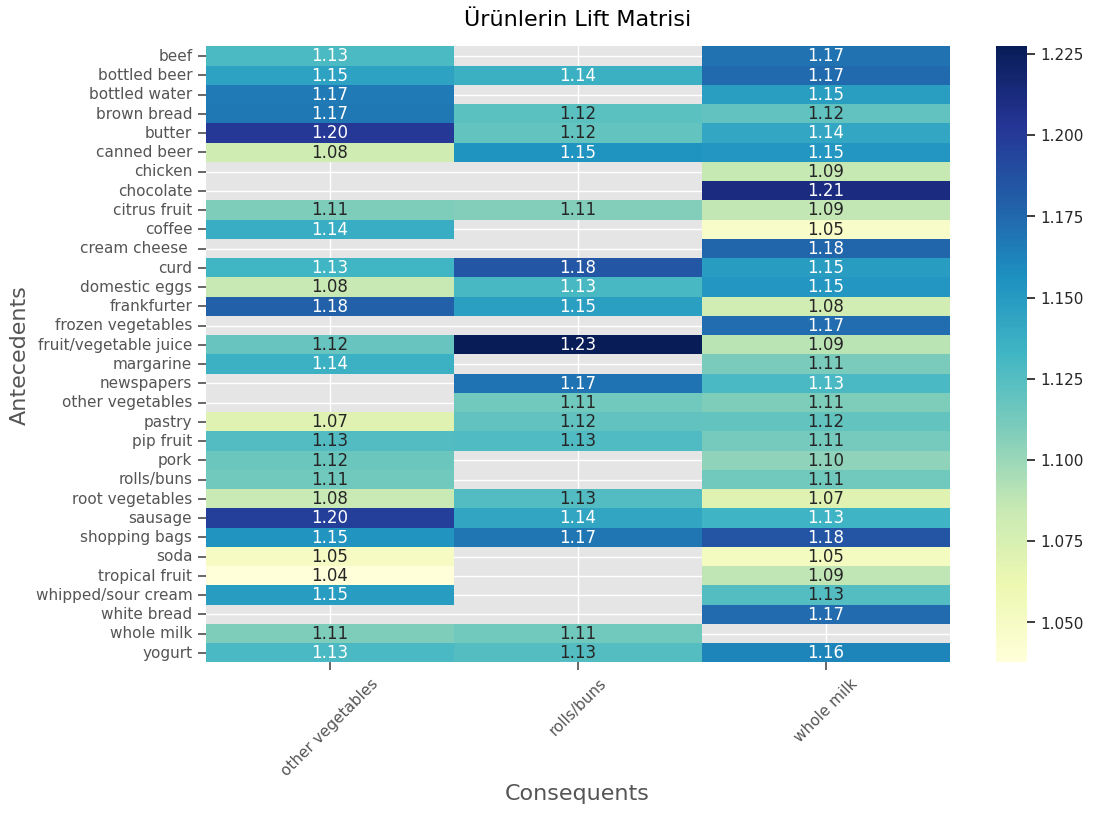

In [ ]:
# Artış değerlerine göre ilişkinin ne kadar güçlü olduğunu öğrenmek için bir ısı haritası çizin
pivot_support = rules_best_eda.pivot(index='antecedents', columns='consequents', values='lift')

sns.set_context("notebook")
plt.style.use('ggplot')
plt.subplots(figsize=(12, 8))
sns.set()
ax = sns.heatmap(data=pivot_support, annot=True, fmt='.2f', cmap='YlGnBu', cbar=True)
plt.title("Ürünlerin Lift Matrisi", fontsize=16, y=1.02)
ax.set_xlabel("Consequents",fontsize=16)
ax.set_ylabel("Antecedents",fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
# Artış değerlerine göre ilişkinin ne kadar güçlü olduğunu öğrenmek için bir ısı haritası çizin
pivot_confidence = rules_best_eda.pivot(index='antecedents', columns='consequents', values='confidence')

fig = ff.create_annotated_heatmap(pivot_confidence.to_numpy().round(2),
                                  x=list(pivot_confidence.columns),
                                  y=list(pivot_confidence.index),
                                  colorscale=['grey', 'orange', 'red'],
                                  font_colors=['white', 'white', 'white'])
fig.update_layout(
    template='simple_white',
    autosize=False,
    width=800,
    height=800,
    title="Confidence Matrix",
    xaxis_title='Consequents',
    yaxis_title='Antecedents',
    legend_title="Legend Title",
    font=dict(
        family="Caliber",
        size=14,
        color="Black"
    )
)
fig.update_layout(title_x=0.22, title_y=0.98)
fig.update_traces(showscale=True)
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# İlk yüzde 10'luk dilimdeki öğeler arasındaki bağlantıları görmek için ağ çizelim.
network_A = list(rules_best_eda["antecedents"].unique())
network_B = list(rules_best_eda["consequents"].unique())
node_list = list(set(network_A+network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)

# 2 Boyutlu yay düzeni kullanarak düğüm pozisyonlarını belirleme
for i,j in rules_best_eda.iterrows():
    G.add_edges_from([(j["antecedents"],j["consequents"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=400)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

# Kenar izleme
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

# Düğüm izleme
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' has {} connections'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

# Grafiği oluşturma ve görüntüleme
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='İlk 10 Yüzdelik Ürünlerin Bağlantısı',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.update_layout(title_x=0.5, title_y=0.96)
iplot(fig)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# tüm kombinasyonların bağlantılarını göstermek için ağ grafiği çizilmiştir.
rules_fix = rules.copy(deep=True)
network_A = list(rules_fix["antecedents"].unique())
network_B = list(rules_fix["consequents"].unique())
node_list = list(set(network_A+network_B))
G = nx.Graph()
for i in node_list:
    G.add_node(i)
for i,j in rules_fix.iterrows():
    G.add_edges_from([(j["antecedents"],j["consequents"])])
pos = nx.spring_layout(G, k=0.5, dim=2, iterations=400)
for n, p in pos.items():
    G.nodes[n]['pos'] = p

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='electric',
        reversescale=False,
        color=[],
        size=8,
        colorbar=dict(
            thickness=10,
            title='Düğüm Bağlantıları',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = str(adjacencies[0]) +' has {} connections'.format(str(len(adjacencies[1])))
    node_trace['text']+=tuple([node_info])

fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Tüm Ürün Ağı',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
fig.update_layout(title_x=0.5, title_y=0.96)
iplot(fig)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

